In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
import numpy as np
import scipy as sp
import pandas as pd
from scipy.interpolate import pchip_interpolate as interp
from scipy.interpolate import pchip

import pickle

# Fused wrapped Fortran wake models
from FortranWake.fused_fortran import FusedFNOJ, MultipleFusedFNOJ, FusedFGCL, MultipleFusedFGCL, AEP_f
from FortranWake.fusedwasp import PlantFromWWH, WTDescFromWTG

# FusedWind
from fusedwind.plant_flow.vt import GenericWindFarmTurbineLayout, WTPC, WeibullWindRoseVT, GenericWindRoseVT

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
wt_desc = WTDescFromWTG('V80-2MW-offshore.wtg').wt_desc
wt_layout = PlantFromWWH('hornsrev1_turbine_nodescription.wwh').wt_layout
get_P = pchip(wt_desc.power_curve[:,0],wt_layout.n_wt*wt_desc.power_curve[:,1])
P_rated = np.sum(wt_layout.wt_array('power_rating'))

1


In [3]:
wt=wt_desc
PCI = pchip(wt.power_curve[:,0],wt.power_curve[:,1])
CTCI = pchip(wt.c_t_curve[:,0],wt.c_t_curve[:,1])
u_c = np.linspace(wt.cut_in_wind_speed,wt.cut_out_wind_speed,100,endpoint=True)
p_c = PCI(u_c)
ct_c = CTCI(u_c)

In [4]:
for wt in wt_layout.wt_list:
    PCI = pchip(wt.power_curve[:,0],wt.power_curve[:,1])
    CTCI = pchip(wt.c_t_curve[:,0],wt.c_t_curve[:,1])
    u_c = np.linspace(wt.cut_in_wind_speed,wt.cut_out_wind_speed,211,endpoint=True)
    p_c = PCI(u_c)
    ct_c = CTCI(u_c)
    wt.power_curve = np.vstack([u_c,p_c]).T
    wt.c_t_curve = np.vstack([u_c,ct_c]).T

In [5]:
df = pd.DataFrame([wt_layout.create_dict(n) for n in range(wt_layout.n_wt)])

In [6]:
def circles(x, y, s, c='b', ax=None, vmin=None, vmax=None, **kwargs):
    """
    Make a scatter of circles plot of x vs y, where x and y are sequence 
    like objects of the same lengths. The size of circles are in data scale.

    Parameters
    ----------
    x,y : scalar or array_like, shape (n, )
        Input data
    s : scalar or array_like, shape (n, ) 
        Radius of circle in data scale (ie. in data unit)
    c : color or sequence of color, optional, default : 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs.
        Note that `c` should not be a single numeric RGB or
        RGBA sequence because that is indistinguishable from an array of
        values to be colormapped.  `c` can be a 2-D array in which the
        rows are RGB or RGBA, however.
    ax : Axes object, optional, default: None
        Parent axes of the plot. It uses gca() if not specified.
    vmin, vmax : scalar, optional, default: None
        `vmin` and `vmax` are used in conjunction with `norm` to normalize
        luminance data.  If either are `None`, the min and max of the
        color array is used.  (Note if you pass a `norm` instance, your
        settings for `vmin` and `vmax` will be ignored.)

    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`

    Other parameters
    ----------------
    kwargs : `~matplotlib.collections.Collection` properties
        eg. alpha, edgecolors, facecolors, linewidths, linestyles, norm, cmap

    Examples
    --------
    a = np.arange(11)
    circles(a, a, a*0.2, c=a, alpha=0.5, edgecolor='none')

    License
    --------
    This code is under [The BSD 3-Clause License]
    (http://opensource.org/licenses/BSD-3-Clause)
    """
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection
    import pylab as plt
    #import matplotlib.colors as colors

    if ax is None:
        ax = plt.gca()    

    if isinstance(c,basestring):
        color = c     # ie. use colors.colorConverter.to_rgba_array(c)
    else:
        color = None  # use cmap, norm after collection is created
    kwargs.update(color=color)

    if np.isscalar(x):
        patches = [Circle((x, y), s),]
    elif np.isscalar(s):
        patches = [Circle((x_,y_), s) for x_,y_ in zip(x,y)]
    else:
        patches = [Circle((x_,y_), s_) for x_,y_,s_ in zip(x,y,s)]
    collection = PatchCollection(patches, **kwargs)

    if color is None:
        collection.set_array(np.asarray(c))
        if vmin is not None or vmax is not None:
            collection.set_clim(vmin, vmax)

    ax.add_collection(collection)
    ax.autoscale_view()
    return collection

(423000.0, 430000.0, 6146000.0, 6153000.0)

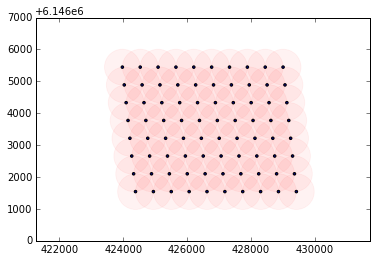

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
circles(df.x, df.y, s=7.*df.rotor_diameter, c='r', alpha=0.05,edgecolors='none',ax=ax)
circles(df.x, df.y, s=df.rotor_diameter/2., c=df.power_rating,edgecolors='none',ax=ax)
ax.axis('equal')

### Single flow NOJ

In [8]:
NOJ_s = FusedFNOJ()
NOJ_s.wind_speed=4.2#8.0
NOJ_s.wind_direction = 270.0
NOJ_s.wake_expansion = 0.05
NOJ_s.wt_layout = wt_layout
NOJ_s.run()
NOJ_s.power/1e6

1.1702206305577563

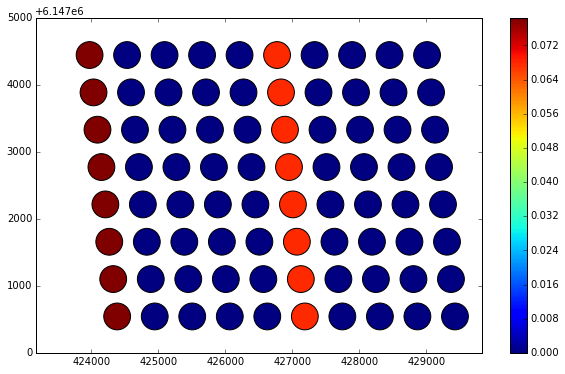

In [9]:
fig=plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
co=circles(df.x, df.y, s=5*df.rotor_diameter/2., c=NOJ_s.wt_power[0]/1e6,edgecolors='none',ax=ax)
ax.axis('equal')
fig.colorbar(co)
print

### Single Flow GCL

In [22]:
GCL_s = FusedFGCL()
GCL_s.wind_speed=4.2
GCL_s.wind_direction = 270.
GCL_s.tubulence_intensity = 0.07
GCL_s.wt_layout = wt_layout
GCL_s.run()
GCL_s.power/1e6

0.62679959985745137

In [23]:
#GCL_s.wt_wind_speed

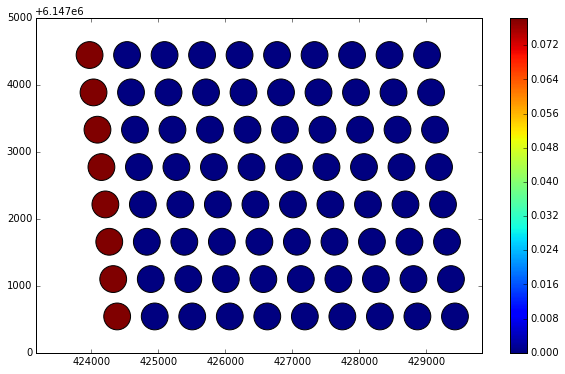

In [24]:
fig=plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
co = circles(df.x, df.y, s=5*df.rotor_diameter/2., c=GCL_s.wt_power[0]/1e6, edgecolors='none',ax=ax)
ax.axis('equal')
fig.colorbar(co)
print

###Multiple flow NOJ

In [81]:
wind_speeds = [i for i in np.linspace(4.0,25.,num=43,endpoint=True)]
wind_directions = [i for i in np.linspace(0.,360.,num=720,endpoint=False)]

In [82]:
WS,WD = np.meshgrid(np.array(wind_speeds),np.array(wind_directions))
WS,WD = WS.flatten(),WD.flatten()

In [83]:
NOJ = MultipleFusedFNOJ()
NOJ.wind_speeds=WS
NOJ.wind_directions=WD
NOJ.wt_layout = wt_layout
NOJ.wake_expansion=0.050
NOJ.run()
NOJ.power/1e6 #Power[iWD,iWD]

array([   0.666     ,    4.25621974,    8.09492533, ...,  160.        ,
        160.        ,  160.        ])

In [84]:
NOJ.wt_power

array([[   66600.        ,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       [  103244.48075988,    93230.86392353,    66769.72260929, ...,
           66769.72260929,    87859.87693104,    67171.73912716],
       [  153931.81581458,    96362.50471081,    99115.72828813, ...,
           99115.72828813,    89511.6416225 ,    94912.16684535],
       ..., 
       [ 2000000.        ,  2000000.        ,  2000000.        , ...,
         2000000.        ,  2000000.        ,  2000000.        ],
       [ 2000000.        ,  2000000.        ,  2000000.        , ...,
         2000000.        ,  2000000.        ,  2000000.        ],
       [ 2000000.        ,  2000000.        ,  2000000.        , ...,
         2000000.        ,  2000000.        ,  2000000.        ]])

In [85]:
# Saving the NOJ:
with open('HR1_NOJ.pickle', 'w') as f:
    pickle.dump(NOJ, f)

# Getting back the objects:
with open('HR1_NOJ.pickle') as f:
    NOJ = pickle.load(f)

In [86]:
df_NOJ = pd.DataFrame(data=np.vstack([WS,WD,
                                      (get_P(WS)-NOJ.power)/P_rated]).T,  
#                                      (get_P(WS)-NOJ.power)/get_P(WS)]).T,                                      
                     columns=['WS','WD','P'])
df_NOJ.head()

,WS,WD,P
0,4.0,0,0.029138
1,4.5,0,0.025023
2,5.0,0,0.026407
3,5.5,0,0.032938
4,6.0,0,0.042300


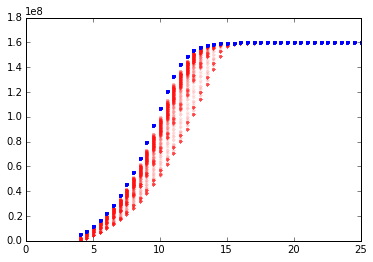

In [36]:
plt.plot(df_NOJ.WS,NOJ.power,'.r',alpha=0.05)
plt.plot(df_NOJ.WS,get_P(df_NOJ.WS),'.')

In [37]:
hdf = df_NOJ.groupby(['WS','WD']).mean().P
hdfreset = hdf.reset_index()
hdfreset.columns = ['WS','WD','P']
hdfpivot=hdfreset.pivot('WS','WD')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Xi,Yi = np.meshgrid(X, Y)
Z=hdfpivot.values

<matplotlib.colorbar.Colorbar instance at 0x1129525f0>

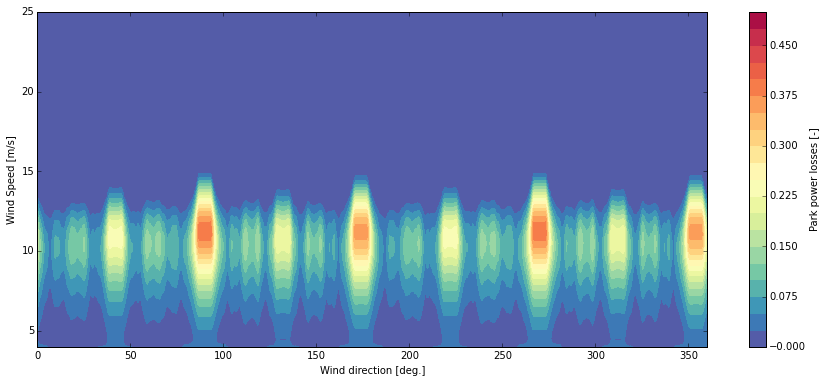

In [46]:
levels=np.arange(-1e-6,0.51,0.025)
fig = plt.figure(figsize=[15,6])
ax = plt.subplot(1,1,1)
CS=plt.contourf(Xi,Yi,Z,levels=levels,cmap=plt.cm.Spectral_r)
ax.set_xlim([0.,360.])
ax.set_xlabel('Wind direction [deg.]')
ax.set_ylim([4.,25.])
ax.set_ylabel('Wind Speed [m/s]')
plt.colorbar(CS,label='Park power losses [-]')
#fig.savefig('HR_WF_Power_Curve.pdf',format='pdf',bbox_inches='tight')

In [47]:
Xpolar = Yi*np.cos(np.deg2rad(Xi))
Ypolar = Yi*np.sin(np.deg2rad(Xi))

<matplotlib.colorbar.Colorbar instance at 0x110ec4cf8>

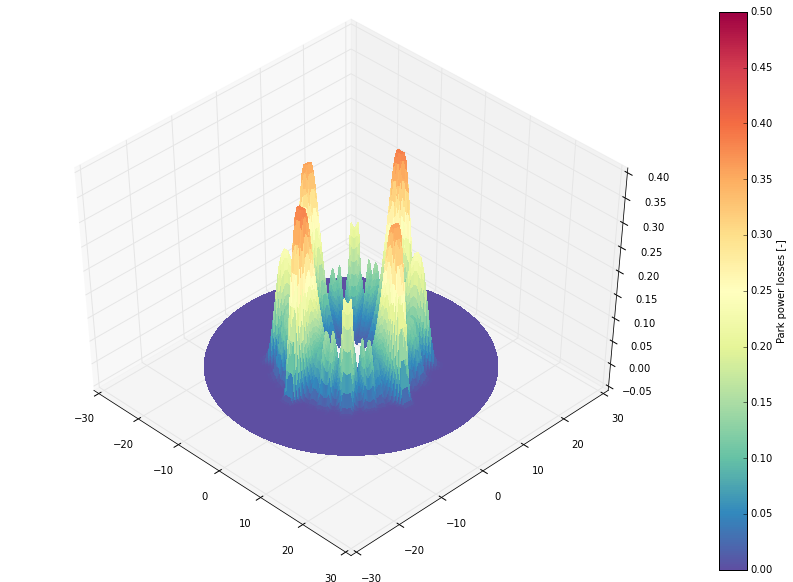

In [50]:
fig = plt.figure(figsize=[15,10])
ax = fig.gca(projection='3d')
surf = ax.plot_surface(Xpolar, Ypolar, Z, rstride=1,cstride=1,
    cmap=plt.cm.Spectral_r,vmin=0., vmax=.5,
    linewidth=0., antialiased=False)
#ax.set_zlim(0, 1.01)
ax.view_init(elev=45., azim=-45)
fig.colorbar(surf,label='Park power losses [-]')

###Multiple flow GCL

In [60]:
wind_speeds = [i for i in np.linspace(4.0,25.,num=43,endpoint=True)]
wind_directions = [i for i in np.linspace(0.,360.,num=720,endpoint=False)]
tis = [i for i in np.logspace(np.log10(0.04),np.log10(0.20),num=6,endpoint=True)]

In [61]:
WS,WD = np.meshgrid(np.array(wind_speeds),np.array(wind_directions))
WS,TI = np.meshgrid(WS.flatten(),np.array(tis))
WD,__ = np.meshgrid(WD.flatten(),np.array(tis))
WS,WD,TI = WS.flatten(),WD.flatten(),TI.flatten()

In [62]:
GCL = MultipleFusedFGCL()
GCL.wind_speeds=list(WS)
GCL.wind_directions=list(WD)
GCL.turbulence_intensities=list(TI)
GCL.wt_layout = wt_layout
GCL.run()
GCL.power/1e6 #Power[iWD,iWD]

array([   0.666     ,    6.37679288,    9.70193571, ...,  160.        ,
        160.        ,  160.        ])

In [63]:
# Saving the GCL:
with open('HR1_GCL.pickle', 'w') as f:
    pickle.dump(GCL, f)

# Getting back the objects:
with open('HR1_GCL.pickle') as f:
    GCL = pickle.load(f)

In [71]:
df_GCL = pd.DataFrame(data=np.vstack([WS,WD,TI,
                                      (get_P(WS)-GCL.power)/P_rated]).T,
#                                      (get_P(WS)-GCL.power)/get_P(WS)]).T,                                      
                     columns=['WS','WD','TI','P'])
df_GCL.head()

,WS,WD,TI,P
0,4.0,0,0.04,0.029138
1,4.5,0,0.04,0.011769
2,5.0,0,0.04,0.016363
3,5.5,0,0.04,0.020661
4,6.0,0,0.04,0.026525


```python
df_GCL = pd.DataFrame(data=np.vstack([ws_mesh.flatten(),
                                      wd_mesh.flatten(),
                                      GCL.turbulence_intensity*np.ones_like(wd_mesh.flatten()),
                                      (get_P(ws_mesh.flatten())-GCL.power.flatten())/get_P(ws_mesh.flatten())]).T,                                      
#                                      (get_P(ws_mesh.flatten())-GCL.power.flatten())/P_rated]).T,
                     columns=['WS','WD','TI','P'])
df_GCL.head()
plt.plot(ws_mesh.flatten(),get_P(ws_mesh.flatten()),'.')
plt.plot(ws_mesh.flatten(),GCL.power.flatten(),'.r')
```

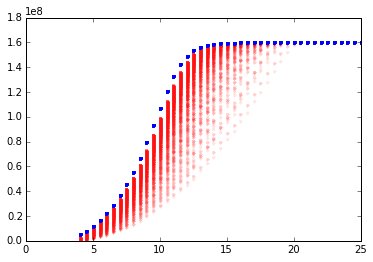

In [72]:
plt.plot(WS,GCL.power,'.r',alpha=0.05)
plt.plot(WS,get_P(WS),'.')

In [73]:
list(set(df_GCL.TI))

[0.076146157548635143,
 0.10506111217615072,
 0.20000000000000004,
 0.055189186458448621,
 0.14495593273553914,
 0.040000000000000008]

In [74]:
hdf = df_GCL.groupby(['WS','WD']).mean().P
hdfreset = hdf.reset_index()
hdfreset.columns = ['WS','WD','P']
hdfpivot=hdfreset.pivot('WS','WD')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Xi,Yi = np.meshgrid(X, Y)
Z=hdfpivot.values

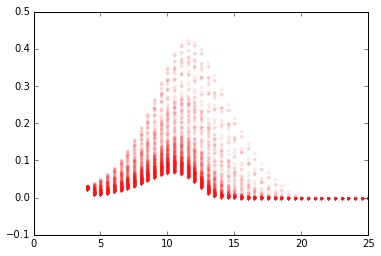

In [75]:
plt.plot(Yi,Z,'.r',alpha=0.05)
print

<matplotlib.colorbar.Colorbar instance at 0x1120fa1b8>

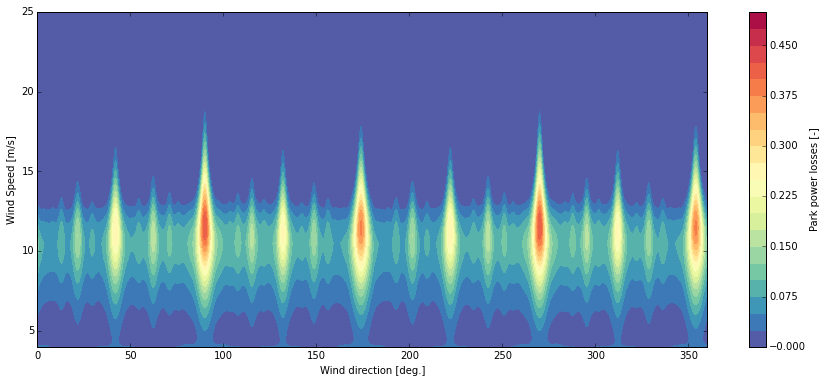

In [77]:
levels=np.arange(-1e-6,.5,0.025)
fig = plt.figure(figsize=[15,6])
ax = plt.subplot(1,1,1)
CS=plt.contourf(Xi,Yi,Z,levels=levels,cmap=plt.cm.Spectral_r)
ax.set_xlim([0.,360.])
ax.set_xlabel('Wind direction [deg.]')
ax.set_ylim([4.,25.])
ax.set_ylabel('Wind Speed [m/s]')
fig.colorbar(CS,label='Park power losses [-]')
#fig.savefig('HR_WF_Power_Curve.pdf',format='pdf',bbox_inches='tight')

In [78]:
Xpolar = Yi*np.cos(np.deg2rad(Xi))
Ypolar = Yi*np.sin(np.deg2rad(Xi))

<matplotlib.colorbar.Colorbar instance at 0x13ff755a8>

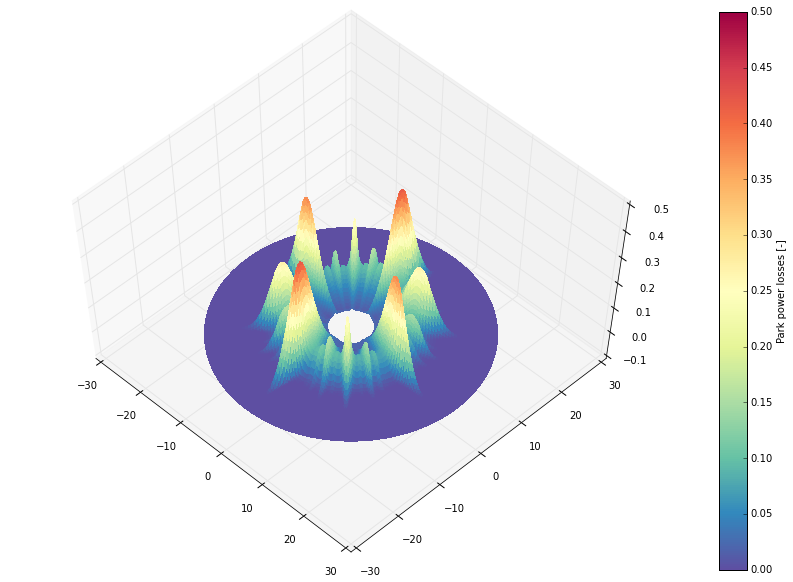

In [80]:
fig = plt.figure(figsize=[15,10])
ax = fig.gca(projection='3d')
surf = ax.plot_surface(Xpolar, Ypolar, Z, rstride=1,cstride=1,
    cmap=plt.cm.Spectral_r,vmin=0., vmax=.5,
    linewidth=0., antialiased=False)
#ax.set_zlim(0, 0.5)
ax.view_init(elev=60., azim=-45)
fig.colorbar(surf,label='Park power losses [-]')

In [11]:
pow_dif = ( 2.*np.abs(NOJ.power-GCL.power)/(NOJ.power+GCL.power) ).flatten()
np.where(pow_dif>0.05)

(array([  1,   2,   3,   4,   5,  78,  79,  80,  81,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 166, 188, 189, 190, 191, 192, 193, 199,
        200, 201, 202, 203, 276, 277, 278, 279, 297, 298, 299, 300, 301,
        302, 303, 304, 305, 364, 367, 386, 387, 388, 389, 390, 391, 397,
        398, 399, 400, 401]),)

## AEP with fortran fused wake models

In [12]:
# The wind rose
weibull_array = np.array([[  0.00000000e+00,   3.59673400e-02,  9.22422800e+00,   2.38867200e+00],
                         [  3.00000000e+01,   3.94977300e-02,   9.86435600e+00,   2.44726600e+00],
                         [  6.00000000e+01,   5.17838000e-02,   9.65220200e+00,   2.41992200e+00],
                         [  9.00000000e+01,   6.99794900e-02,   9.98217800e+00,   2.58789100e+00],
                         [  1.20000000e+02,   8.36383000e-02,   1.00946000e+01,   2.74804700e+00],
                         [  1.50000000e+02,   6.43412500e-02,   9.64369000e+00,   2.59179700e+00],
                         [  1.80000000e+02,   8.64220000e-02,   9.63377500e+00,   2.58007800e+00],
                         [  2.10000000e+02,   1.17690000e-01,   1.05678600e+01,   2.54492200e+00],
                         [  2.40000000e+02,   1.51555100e-01,   1.14525200e+01,   2.46679700e+00],
                         [  2.70000000e+02,   1.47361100e-01,   1.17423700e+01,   2.60351600e+00],
                         [  3.00000000e+02,   1.00109800e-01,   1.16923200e+01,   2.62304700e+00],
                         [  3.30000000e+02,   5.16542400e-02,   1.01385800e+01,   2.32226600e+00]])
wind_rose = WeibullWindRoseVT()
wind_rose.wind_directions = weibull_array[:,0]
wind_rose.frequency = weibull_array[:,1]
wind_rose.k = weibull_array[:,3]
wind_rose.A = weibull_array[:,2]

In [13]:
aep = AEP_f(wt_layout=wt_layout,
          wind_rose=wind_rose,
          wf=MultipleFusedFNOJ(),
          wind_speeds=wind_speeds,
          wind_directions=wind_directions,
          scaling=1.0,
          wt_positions=wt_layout.wt_array(attr='position'))
aep.wf.kj = 0.05

aep.run()
print aep.net_aep/1e12
print aep.gross_aep/1e12
print aep.capacity_factor

1.0
0.664661500217
0.747460127199
0.889226697225


In [14]:
aep = AEP_f(wt_layout=wt_layout,
          wind_rose=wind_rose,
          wf=MultipleFusedFGCL(),
          wind_speeds=wind_speeds,
          wind_directions=wind_directions,
          scaling=1.0,
          wt_positions=wt_layout.wt_array(attr='position'))
aep.wf.NG = 4
aep.wf.TI = 0.08

aep.run()
print aep.net_aep/1e12
print aep.gross_aep/1e12
print aep.capacity_factor

1.0
0.659115576439
0.747460127199
0.881807005423


In [25]:
inputs=dict(
            wind_speed=8.0,
            wind_direction = 270.0,
            turbulence_intensity=0.07,
            n_quad_points=5
            )
rosettaGCL = {
    'wind_speed':'ws',
    'wind_direction':'wd',
    'turbulence_intensity':'ti',
    'n_quad_points':'ng'}

In [29]:
for k,v in inputs.iteritems():
    print rosettaGCL[k],v
    

ws 8.0
wd 270.0
ti 0.07
ng 5


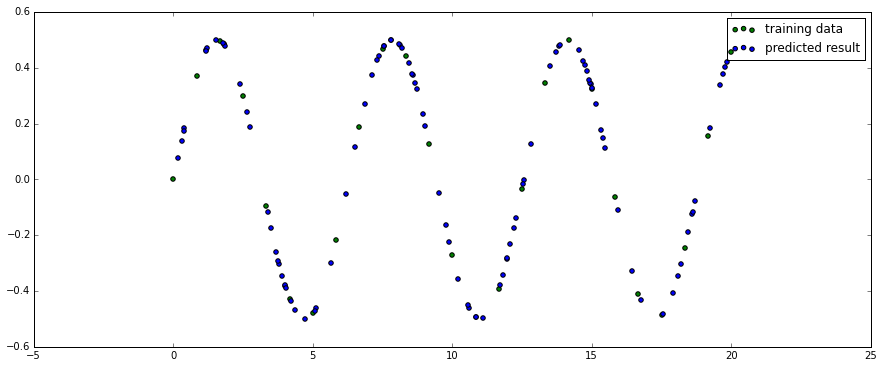

In [376]:
''' Example problem - metamodel of the sine function. '''

import sys
from math import sin

from openmdao.lib.casehandlers.api import DBCaseRecorder
from openmdao.lib.components.api import MetaModel
from openmdao.lib.doegenerators.api import FullFactorial, Uniform
from openmdao.lib.drivers.api import DOEdriver
from openmdao.lib.surrogatemodels.api import FloatKrigingSurrogate
from openmdao.main.api import Assembly, Component, set_as_top
from openmdao.main.datatypes.api import Float


class Sin(Component):
    ''' Simple sine calculation. '''

    x = Float(0.0, iotype="in", units="rad")

    f_x = Float(0.0, iotype="out")

    def execute(self):
        self.f_x = .5*sin(self.x)


class Simulation(Assembly):
    ''' Top level assembly for MetaModel of a sine component using a
    Kriging surrogate.'''

    def configure(self):

        # Our component to be meta-modeled
        self.add("sin_calc", Sin())

        # Another instance of our component for head-to-head comparison with
        # the metamodel.
        self.add("sin_verify", Sin())

        # Create meta_model for f_x as the response
        self.add("sin_meta_model", MetaModel(params = ('x', ),
                                             responses = ('f_x', )))

        # Use Kriging for the f_x output
        self.sin_meta_model.default_surrogate = FloatKrigingSurrogate()

        # Training the MetaModel
        self.add("DOE_Trainer", DOEdriver())
        self.DOE_Trainer.DOEgenerator = FullFactorial()
        self.DOE_Trainer.DOEgenerator.num_levels = 25
        self.DOE_Trainer.add_parameter("sin_calc.x", low=0, high=20)
        self.DOE_Trainer.add_response('sin_calc.f_x')

        # Pass training data to the meta model.
        self.connect('DOE_Trainer.case_inputs.sin_calc.x', 'sin_meta_model.params.x')
        self.connect('DOE_Trainer.case_outputs.sin_calc.f_x', 'sin_meta_model.responses.f_x')

        # Cross-validate the metamodel using random data
        self.add("DOE_Validate", DOEdriver())
        self.DOE_Validate.DOEgenerator = Uniform()
        self.DOE_Validate.DOEgenerator.num_samples = 100
        self.DOE_Validate.add_parameter(("sin_meta_model.x", "sin_verify.x"),
                                        low=0, high=20) # , name="combined_input"
        self.DOE_Validate.add_response("sin_verify.f_x")
        self.DOE_Validate.add_response("sin_meta_model.f_x")

        #Iteration Hierarchy
        self.driver.workflow.add(['DOE_Trainer', 'DOE_Validate'])
        self.DOE_Trainer.workflow.add('sin_calc')
        self.DOE_Validate.workflow.add(['sin_verify', 'sin_meta_model'])


#if __name__ == "__main__":

sim = set_as_top(Simulation())
sim.run()

#This is how you can access any of the data
train_inputs = sim.DOE_Trainer.case_inputs.sin_calc.x
train_actual = sim.DOE_Trainer.case_outputs.sin_calc.f_x
inputs = sim.DOE_Validate.case_inputs.sin_meta_model.x
actual = sim.DOE_Validate.case_outputs.sin_verify.f_x
predicted = sim.DOE_Validate.case_outputs.sin_meta_model.f_x

if '--noplot' not in sys.argv:
    fig = plt.figure(figsize=[15,6])
    ax = plt.subplot(1,1,1)

    ax.scatter(train_inputs, train_actual, c='g', label="training data")
    ax.scatter(inputs, predicted, c='b', label="predicted result")
    ax.legend()
